In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
np.set_printoptions(precision=3, suppress=True)

from collections import Counter
from scipy.signal import convolve2d

import time

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation

In [2]:
np.random.seed(seed=123)

### GPT

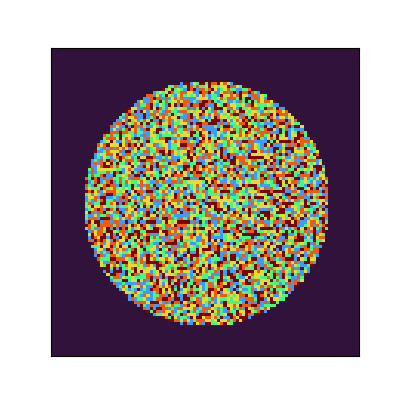

In [4]:
%matplotlib ipympl 

N = 100
pDeath = 0.2
wDead = 11
wRepl = 1
wBoost = 100

nSpecies = 5
speciesIds = np.arange(1, nSpecies + 1, dtype=int)

# Initialization
lattice = np.zeros((N, N), dtype=int)
initDistribution = np.random.choice(speciesIds, size=N * N).reshape(N, N)

Rsq = N**2 / 2 / np.pi
seed_mask = (np.indices((N, N)).T - N / 2)**2.0
seed_mask = seed_mask[:, :, 0] + seed_mask[:, :, 1] > Rsq
initDistribution[seed_mask] = 0
lattice = initDistribution.astype(np.uint8)

replicationDirectionShifts = [
    (0, 1), #:"up", 
    (1, 0), #:"left", 
    (2, 1), #:"down", 
    (1, 2) #:"right"}
]

boostLogic = [
    [4,5,1,3], #  "up": 
    [4,6,0,2], # "left": 
    [6,7,1,3], # "down": 
    [5,7,0,2]  # "right": 
    ]

replMatrix = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])

def computeNeighbours(lattice):
    # Compute wrapped neighbors using numpy's roll function
    down = np.roll(lattice, shift=-1, axis=0)
    up = np.roll(lattice, shift=1, axis=0)
    right = np.roll(lattice, shift=-1, axis=1)
    left = np.roll(lattice, shift=1, axis=1)
    
    down_right = np.roll(down, shift=-1, axis=1)
    down_left = np.roll(down, shift=1, axis=1)
    up_right = np.roll(up, shift=-1, axis=1)
    up_left = np.roll(up, shift=1, axis=1)

    # Stack neighbors along a new last dimension
    # So that neighbors[..., 0] is "up", neighbors[..., 1] is "left", etc.
    return np.stack([up, left, down, right, up_left, up_right, down_left, down_right], axis=-1)

def onehot(a):
    ncols = nSpecies+1
    out = np.zeros( (a.size,ncols), dtype=np.uint8)
    out[np.arange(a.size),a.ravel()] = 1
    out.shape = a.shape + (ncols,)
    return out

def fillNewLattice(lattice, neighborsMatrix):
    # Initialize claims for the entire lattice
    claims = np.zeros((N, N, nSpecies+1), dtype=np.uint16) # i,j,s

    # Calculate the claims from the neighbors for each direction in dIJs
    # replicator direction dIJs = [(0, 1), (1, 0), (2, 1), (1, 2)]
    #                               up,     left,  down,   right 
    
    # for each possible replication direction
    for replicationDirectionId, replicationDirectionShift in enumerate(replicationDirectionShifts):
        replicatorSpecies = neighborsMatrix[..., replicationDirectionId]
        
        boosterSpeciesRequired = replicatorSpecies + 1
        boosterSpeciesRequired[boosterSpeciesRequired > nSpecies] = 1

        claims += wRepl * onehot(replicatorSpecies)
        
        for boostDirectionId in boostLogic[replicationDirectionId]:
            boosterSpecies = neighborsMatrix[..., boostDirectionId]
            correctBoosterSpecies = boosterSpecies * (boosterSpecies == boosterSpeciesRequired)
            claims += wBoost * onehot(correctBoosterSpecies)
    
    # Normalize claims and pick new cells
    claims[..., 0] = wDead
    cumProb = np.cumsum(claims, axis=-1) / claims.sum(axis=-1, keepdims=True)
    rr = np.random.uniform(size=(N, N, 1))
    
    new_cells = (cumProb > rr).argmax(axis=-1) # probabilistic

    return new_cells

def animate(i):
    global lattice

    neighbors = computeNeighbours(lattice)

    survived_mask = np.random.uniform(size=lattice.shape) > pDeath
    died_mask = np.logical_not(survived_mask)
    lattice[died_mask] = 0

    replication_mask = (convolve2d(lattice > 0, replMatrix, mode="same", boundary="wrap") > 0)
    replication_spots = np.logical_and(lattice == 0, replication_mask)
    lattice[replication_spots] = fillNewLattice(lattice, neighbors)[replication_spots]
    lattice[survived_mask] = lattice[survived_mask]

    im1.set_array(lattice)
    return [im1]



######################################
# Plotting
######################################

cmap = "turbo"
my_cmap = plt.get_cmap(cmap)
colors = my_cmap(np.arange(0,nSpecies)) 

fig, ax = plt.subplots(figsize = (4,4),dpi = 100)

im1=ax.imshow(lattice, 
                interpolation='none', 
              cmap = cmap
             )
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

def init():
    im1 = plt.imshow(np.zeros(N,N))
    return [im1]
ani = FuncAnimation(fig, animate, frames=20000, interval=15,blit=False)



# a version with timers

In [ ]:
%matplotlib notebook

import numpy as np
from scipy.signal import convolve2d

timers = {
    "neigh":0,
    "kill":0,
    "replicate":0,
    "plot":0, 
}


N =50
pDeath = 0.2
wDead = 11
wRepl = 1
wBoost = 100


nSpecies = 5
speciesIds = np.arange(1, nSpecies + 1, dtype=int)

# Initialization
lattice = np.zeros((N, N), dtype=int)
initDistribution = np.random.choice(speciesIds, size=N * N).reshape(N, N)

Rsq = N**2 / 2 / np.pi
seed_mask = (np.indices((N, N)).T - N / 2)**2.0
seed_mask = seed_mask[:, :, 0] + seed_mask[:, :, 1] > Rsq
initDistribution[seed_mask] = 0
lattice = initDistribution.astype(np.uint8)


def animate(i):
    global lattice
    
    start = time.time()
    
    neighbors = computeNeighbours(lattice)
    
    stop = time.time()
    timers["neigh"] = stop - start
    
    start = time.time()
    
    survived_mask = np.random.uniform(size=lattice.shape) > pDeath
    died_mask = np.logical_not(survived_mask)
    lattice[died_mask] = 0

    replication_mask = (convolve2d(lattice > 0, replMatrix, mode="same", boundary="wrap") > 0)
    replication_spots = np.logical_and(lattice == 0, replication_mask)
    
    stop = time.time()
    timers["kill"] = stop - start    
    
    start = time.time()
    lattice[replication_spots] = fillNewLattice(lattice, neighbors)[replication_spots]

    lattice[survived_mask] = lattice[survived_mask]
    stop = time.time()
    timers["replicate"] = stop - start
    ############################
    # plot
    ############################
    start = time.time()

    im1.set_array(lattice)

    timerHeights = []
    for rect, h in zip(im2, [v for v in timers.values()]):
        rect.set_height(h)
        timerHeights.append(h)
    ax[1].set_ylim(0, 1.05*max(timerHeights))
    
    
    stop = time.time()
    timers["plot"] = stop - start
    
    
    ccc = Counter(lattice.flatten())
    for s in range(nSpecies+1):
        if not s in ccc:
            ccc[s] = 0
        
    vvv = [v for k,v in sorted([(k,v) for k,v in ccc.items()])]
    for rect, h in zip(im3, vvv):
        rect.set_height(h)
        
    ax[2].set_ylim(0, 1.05*max(vvv))
    
    return [im1, im2, im3]






fig, ax = plt.subplots(1, 3,
                       figsize = (8,4),
                       dpi = 100,
                        gridspec_kw=dict(width_ratios=[5, 1, 1], 
                     wspace=0.3)
                      )

im1=ax[0].imshow(initLattice, 
                interpolation='none', 
              cmap = cmap
             )
ax[0].axes.get_xaxis().set_visible(False)
ax[0].axes.get_yaxis().set_visible(False)
im2=ax[1].bar(x = range(1,1+len(timers)), height = [0.2]*len(timers))
ax[1].set_xticks(range(1,1+len(timers)))
ax[1].set_xticklabels(timers.keys(), rotation = 90)

im3=ax[2].bar(x = range(nSpecies + 1), height = [5]*(nSpecies+1), color = colors)
def init():
    im1 = plt.imshow(np.zeros(N,N))
    im2 = plt.bar(x = range(1,1+len(timers)), height = [0.2]*len(timers), )
    im3 = plt.bar(x = range(nSpecies + 1), height = [5]*(nSpecies+1), colors = colors)
    return [im1, im2, im3]
ani = FuncAnimation(fig, animate, frames=20000, interval=15,
                    #cache_frame_data = True,
                    blit=False
                   )    
    
    



